In [1]:
import sys
sys.path.append('../scripts/')
from puddle_world import *
import itertools 
import collections 

In [2]:
class PolicyEvaluator:  ###policyevaluator6
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T):  #puddle_coef追加
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.goal = goal
        
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        self.value_function, self.final_state_flags =  self.init_value_function() 
        self.policy = self.init_policy()
        self.actions = list(set([tuple(self.policy[i]) for i in self.indexes]))
        
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num)
        self.depths = self.depth_means(puddles, sampling_num)
        
        self.time_interval = time_interval #追加
        self.puddle_coef = puddle_coef
        
    def policy_evaluation_sweep(self): #追加
        for index in self.indexes:
            if not self.final_state_flags[index]:
                self.value_function[index] = self.action_value(tuple(self.policy[index]), index) #actionはタプルに直してから与える
    
    def action_value(self, action, index): #追加
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]:  #index[2]: 方角のインデックス
            after = tuple(self.edge_correction(np.array(index).T + delta) ) #indexに差分deltaを足してはみ出し処理の後にタプルにする
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval
            value += (self.value_function[after] + reward) * prob

        return value
            
    def edge_correction(self, index): #追加
        index[2] = (index[2] + self.index_nums[2])%self.index_nums[2] #方角の処理
                
        return index
        
    def depth_means(self, puddles, sampling_num):
        ###セルの中の座標を均等にsampling_num**2点サンプリング###
        dx = np.linspace(0, self.widths[0], sampling_num) 
        dy = np.linspace(0, self.widths[1], sampling_num)
        samples = list(itertools.product(dx, dy))
        
        tmp = np.zeros(self.index_nums[0:2]) #深さの合計が計算されて入る
        for xy in itertools.product(range(self.index_nums[0]), range(self.index_nums[1])):
            for s in samples:
                pose = self.pose_min + self.widths*np.array([xy[0], xy[1], 0]).T + np.array([s[0], s[1], 0]).T #セルの中心の座標
                for p in puddles:
                    tmp[xy] += p.depth*p.inside(pose) #深さに水たまりの中か否か（1 or 0）をかけて足す
                        
            tmp[xy] /= sampling_num**2 #深さの合計から平均値に変換
                       
        return tmp
    
    def init_state_transition_probs(self, time_interval, sampling_num):
        ###セルの中の座標を均等にsampling_num**3点サンプリング###
        dx = np.linspace(0.001, self.widths[0]*0.999, sampling_num) #隣のセルにはみ出さないように端を避ける
        dy = np.linspace(0.001, self.widths[1]*0.999, sampling_num)
        dt = np.linspace(0.001, self.widths[2]*0.999, sampling_num)
        samples = list(itertools.product(dx, dy, dt))
        
        ###各行動、各方角でサンプリングした点を移動してインデックスの増分を記録###
        tmp = {}
        for a in self.actions:
            for i_t in range(self.index_nums[2]):
                transitions = []
                for s in samples:
                    before = np.array([s[0], s[1], s[2] + i_t*self.widths[2]]).T + self.pose_min  #遷移前の姿勢
                    before_index = np.array([0, 0, i_t]).T                                                      #遷移前のインデックス
                
                    after = IdealRobot.state_transition(a[0], a[1], time_interval, before)   #遷移後の姿勢
                    after_index = np.floor((after - self.pose_min)/self.widths).astype(int)   #遷移後のインデックス
                    
                    transitions.append(after_index - before_index)                                  #インデックスの差分を追加
                    
                unique, count = np.unique(transitions, axis=0, return_counts=True)   #集計（どのセルへの遷移が何回か）
                probs = [c/sampling_num**3 for c in count]                   #サンプル数で割って確率にする
                tmp[a,i_t] = list(zip(unique, probs))
                
        return tmp
        
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums,2]) #制御出力が2次元なので、配列の次元を4次元に
        for index in self.indexes:
            center = self.pose_min + self.widths*(np.array(index).T + 0.5)  #セルの中心の座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goal)
            
        return tmp
        
    def init_value_function(self): 
        v = np.empty(self.index_nums) #全離散状態を要素に持つ配列を作成
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index          #xy平面で左下の座標
        x_max, y_max, _ = self.pose_min + self.widths*(index + 1) #右上の座標（斜め上の離散状態の左下の座標）
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] #4隅の座標
        return all([self.goal.inside(np.array(c).T) for c in corners ])

In [3]:
import seaborn as sns   ###policyevaluator6create

puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
pe = PolicyEvaluator(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.1, 10)

counter = 0 #スイープの回数

<IPython.core.display.Javascript object>


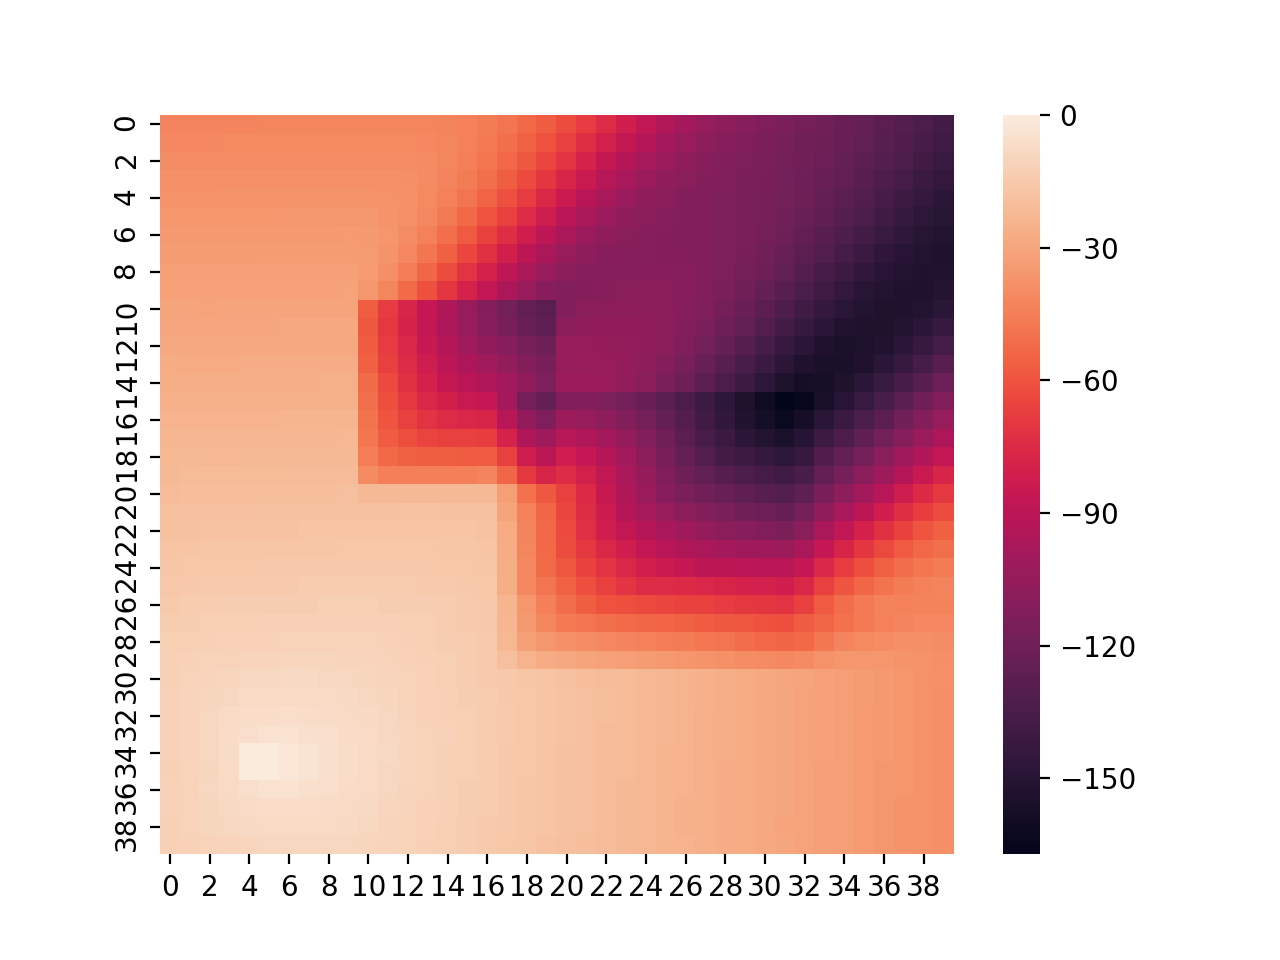

500


In [9]:
for i in range(300):   ###policyevaluator6exec
    pe.policy_evaluation_sweep()
    counter += 1

v = pe.value_function[:, :, 18]
sns.heatmap(np.rot90(v), square=False)
plt.show()
print(counter)